In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from tsfresh import extract_features
import os

df_train = pd.read_csv(f'../data/interim/train_data/all_train.csv',parse_dates=['date'])
data_dict = pd.read_json(f'../data/interim/data_dictionary_v1.json')
df_test = pd.read_csv(f'../data/interim/test_data/all_test.csv',parse_dates=['date'])

cols = df_test.columns
df_all_test = pd.concat([df_train[cols],df_test],keys = ['train','test'])
df_all_test.sample(10)


date  primary_cleaner.input.copper_sulfate  \
train 7311  2017-03-16 14:59:59+00:00                             75.214460   
      13103 2018-03-14 22:59:59+00:00                            194.560330   
      10392 2017-07-22 23:59:59+00:00                            103.017318   
      8819  2017-05-18 10:59:59+00:00                             12.341268   
      7862  2017-04-08 13:59:59+00:00                            145.264969   
      10779 2017-08-08 02:59:59+00:00                            156.070643   
      14194 2018-04-29 09:59:59+00:00                            183.842620   
      10550 2017-07-29 13:59:59+00:00                             95.459725   
      3294  2016-05-31 05:59:59+00:00                            129.979421   
test  2630  2016-12-19 14:59:59+00:00                            209.885178   

             primary_cleaner.input.depressant  \
train 7311                           5.550631   
      13103                         10.316050   
      10392                          4.473228   
      8819                           0.045912   
      7862                           5.994680   
      10779                          4.978090   
      14194                         10.039533   
      10550                          6.003591   
      3294                           8.597387   
test  2630                          11.397746   

             primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
train 7311                          4.970000                        0.534310   
      13103                         7.130000                        0.903231   
      10392                         7.330000                        0.473523   
      8819                          5.850000                        0.011875   
      7862                          7.380000                        0.309529   
      10779                         6.760000                        0.735382   
      14194                         7.130000                        1.111036   
      10550                         7.890000                        0.398067   
      3294                          8.340000                        1.469371   
test  2630                          7.393333                        1.453572   

             primary_cleaner.state.floatbank8_a_air  \
train 7311                              1662.676732   
      13103                             1698.774459   
      10392                             1399.642337   
      8819                              1741.543233   
      7862                              1667.122878   
      10779                             1504.871041   
      14194                             1724.643578   
      10550                             1398.440681   
      3294                              1503.151010   
test  2630                              1496.738081   

             primary_cleaner.state.floatbank8_a_level  \
train 7311                                -499.680843   
      13103                               -500.678418   
      10392                               -499.696035   
      8819                                -498.835962   
      7862                                -499.655817   
      10779                               -500.107895   
      14194                               -500.135919   
      10550                               -500.492523   
      3294                                -500.092804   
test  2630                                -500.481917   

             primary_cleaner.state.floatbank8_b_air  \
train 7311                              1733.836824   
      13103                             1699.555198   
      10392                             1402.779662   
      8819                              1751.367001   
      7862                              1750.288922   
      10779                             1501.715265   
      14194                             1728.568864   
      10550                             1402.027661   
      3294   

Show data_dict with column descriptions:

In [39]:
print(f'Train shape = {df_train.shape} , test shape = {df_test.shape}')

Train shape = (16860, 87) , test shape = (5856, 53)


In [41]:
df_test.date.describe()

count                          5856
unique                         5856
top       2017-10-01 00:59:59+00:00
freq                              1
first     2016-09-01 00:59:59+00:00
last      2017-12-31 23:59:59+00:00
Name: date, dtype: object

There are some columns with `output` in the name.. Those are not available at the test prediction, and thus not super useful yet. Although in TODO list I'd add a possibility to build the model using `output` predictors and compare on local CV the quality of predictions with the model that uses test columns only

In [3]:
pd.set_option('display.max_rows',10)
data_dict

,description,is_input,is_output,is_state,is_target,name,units
0,Timestamp of measurements,False,False,False,False,date,None
1,Plant Feed rate t/hr,True,False,False,False,rougher.input.feed_rate,t/hr
2,Plant Feed Pb%,True,False,False,False,rougher.input.feed_pb,%
3,Plant Feed Zn%,True,False,False,False,rougher.input.feed_zn,%
4,Plant Feed Fe%,True,False,False,False,rougher.input.feed_fe,%
...,...,...,...,...,...,...,...
82,Float Bank 5 Cell B Level,False,False,True,False,secondary_cleaner.state.floatbank5_b_level,Unknown
83,Float Bank 5 Cell A Air,False,False,True,False,secondary_cleaner.state.floatbank5_a_air,Unknown
84,Float Bank 5 Cell B Air,False,False,True,False,secondary_cleaner.state.floatbank5_b_air,Unknown
85,Float Bank 6 Cell A Level,False,False,True,False,secondary_cleaner.state.floatbank6_a_level,Unknown


### Filter to features available both in train and test, and fill the NAs using padding left to right

In [16]:
12 % 5

2

In [19]:
df_grouped = df_all_test.fillna(method = 'ffill')
df_grouped.shape
df_grouped['hour'] = df_grouped['date'].dt.hour

df_tsfresh = df_grouped.reset_index(drop=True).set_index('date')
df_tsfresh = df_tsfresh[(df_tsfresh.hour % 4) == 0].drop('hour',axis = 1)
df_tsfresh

,primary_cleaner.input.copper_sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00+00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 04:00:00+00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 08:00:00+00:00,131.781026,12.465718,7.25,0.885535,1601.670053,-499.548891,1598.804355,-499.689644,1601.689285,-500.484957,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
2016-01-15 12:00:00+00:00,147.944885,12.481529,7.25,0.893913,1603.053015,-499.728573,1600.537532,-500.096021,1597.568005,-499.601040,...,13.983963,-503.675714,11.928745,-500.583183,9.970359,-498.822343,8.016377,-499.013145,14.000032,-600.024741
2016-01-15 16:00:00+00:00,147.591165,12.517364,7.25,0.959430,1602.999120,-500.526448,1597.866105,-499.798253,1598.796914,-498.214347,...,14.031220,-503.471307,11.966426,-500.656842,10.051620,-498.318772,8.018091,-499.696138,13.958937,-599.213013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 04:59:59+00:00,189.439828,16.008396,8.07,0.881950,1398.506688,-503.076112,1396.317692,-497.929866,1396.105827,-499.376997,...,14.045226,-499.421767,12.009828,-500.024489,7.949260,-499.801473,5.959555,-499.785827,8.993141,-508.148163
2017-12-31 08:59:59+00:00,183.531945,15.993966,8.07,0.898512,1398.919175,-500.420522,1403.632064,-498.848238,1396.892881,-500.193519,...,13.978927,-499.798108,11.994358,-499.984593,8.014689,-499.943223,6.000928,-499.882958,8.982384,-503.605414
2017-12-31 12:59:59+00:00,177.405012,15.984476,8.07,0.894480,1398.386535,-500.066376,1398.601157,-500.118035,1398.039229,-499.647822,...,14.019744,-500.645051,12.097232,-499.918724,8.050697,-499.748441,6.009363,-499.753859,9.001746,-502.504685


In [20]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import extract_features, MinimalFCParameters,EfficientFCParameters
d = EfficientFCParameters()
del d['friedrich_coefficients']
del d['max_langevin_fixed_point']
del d['autocorrelation']
del d['agg_autocorrelation']
del d['cwt_coefficients']
del d['large_standard_deviation']
del d['symmetry_looking']
del d['partial_autocorrelation']
del d['index_mass_quantile']
del d['spkt_welch_density']
del d['change_quantiles']
del d['fft_aggregated']
del d['fft_coefficient']
del d['agg_linear_trend']
d

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'maximum': None,
 'minimum': None,
 'time_reversal_

In [21]:
#df_features = extract_features(df_grouped[["primary_cleaner.state.floatbank8_a_air",'date','id']].head(1000), column_sort="date",column_id='id',n_jobs=4)
dfs = {}
for c in df_tsfresh.columns:
    print(f'Working on {c}...')
    df_shift, y = make_forecasting_frame(df_tsfresh[c], kind="price", max_timeshift=3*10, rolling_direction=1)
    X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value",
                         impute_function=impute,show_warnings=False, default_fc_parameters=d,n_jobs=4)
    dfs[c] = X

Working on primary_cleaner.input.copper_sulfate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


Working on primary_cleaner.input.depressant...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.68s/it]


Working on primary_cleaner.input.feed_size...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.15s/it]


Working on primary_cleaner.input.xanthate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.96s/it]


Working on primary_cleaner.state.floatbank8_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  1.30s/it]


Working on primary_cleaner.state.floatbank8_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


Working on primary_cleaner.state.floatbank8_b_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:44<00:00,  2.20s/it]


Working on primary_cleaner.state.floatbank8_b_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  2.81s/it]


Working on primary_cleaner.state.floatbank8_c_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


Working on primary_cleaner.state.floatbank8_c_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  1.13s/it]


Working on primary_cleaner.state.floatbank8_d_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.35s/it]


Working on primary_cleaner.state.floatbank8_d_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.26s/it]


Working on rougher.input.feed_fe...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:44<00:00,  1.23s/it]


Working on rougher.input.feed_pb...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


Working on rougher.input.feed_rate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  2.56s/it]


Working on rougher.input.feed_size...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.34s/it]


Working on rougher.input.feed_sol...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:53<00:00,  1.87s/it]


Working on rougher.input.feed_zn...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:51<00:00,  1.63s/it]


Working on rougher.input.floatbank10_copper_sulfate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:44<00:00,  1.31s/it]


Working on rougher.input.floatbank10_xanthate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.60s/it]


Working on rougher.input.floatbank11_copper_sulfate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


Working on rougher.input.floatbank11_xanthate...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:48<00:00,  1.48s/it]


Working on rougher.state.floatbank10_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:52<00:00,  1.49s/it]


Working on rougher.state.floatbank10_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:47<00:00,  2.40s/it]


Working on rougher.state.floatbank10_b_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


Working on rougher.state.floatbank10_b_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  2.20s/it]


Working on rougher.state.floatbank10_c_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  1.36s/it]


Working on rougher.state.floatbank10_c_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  1.60s/it]


Working on rougher.state.floatbank10_d_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  1.44s/it]


Working on rougher.state.floatbank10_d_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.21s/it]


Working on rougher.state.floatbank10_e_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:55<00:00,  2.18s/it]


Working on rougher.state.floatbank10_e_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:48<00:00,  1.56s/it]


Working on rougher.state.floatbank10_f_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:49<00:00,  2.79s/it]


Working on rougher.state.floatbank10_f_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:44<00:00,  1.84s/it]


Working on secondary_cleaner.state.floatbank2_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:44<00:00,  1.43s/it]


Working on secondary_cleaner.state.floatbank2_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  1.02it/s]


Working on secondary_cleaner.state.floatbank2_b_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:45<00:00,  1.36s/it]


Working on secondary_cleaner.state.floatbank2_b_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:49<00:00,  2.10s/it]


Working on secondary_cleaner.state.floatbank3_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:49<00:00,  1.22s/it]


Working on secondary_cleaner.state.floatbank3_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:49<00:00,  1.51s/it]


Working on secondary_cleaner.state.floatbank3_b_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Working on secondary_cleaner.state.floatbank3_b_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:48<00:00,  1.45s/it]


Working on secondary_cleaner.state.floatbank4_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Working on secondary_cleaner.state.floatbank4_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:47<00:00,  1.92s/it]


Working on secondary_cleaner.state.floatbank4_b_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  1.79s/it]


Working on secondary_cleaner.state.floatbank4_b_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:47<00:00,  1.49s/it]


Working on secondary_cleaner.state.floatbank5_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:50<00:00,  1.67s/it]


Working on secondary_cleaner.state.floatbank5_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:47<00:00,  1.40s/it]


Working on secondary_cleaner.state.floatbank5_b_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


Working on secondary_cleaner.state.floatbank5_b_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Working on secondary_cleaner.state.floatbank6_a_air...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:49<00:00,  1.49s/it]


Working on secondary_cleaner.state.floatbank6_a_level...


/home/geoanton/anaconda3/envs/zinc/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 20/20 [00:50<00:00,  1.32s/it]


In [48]:
cols = X.apply(np.any)
X.loc[:,cols].shape

(3999, 403)

In [25]:
dfs['primary_cleaner.input.copper_sulfate']

(5678, 98)

In [29]:
df_tsfresh_feats = pd.concat(dfs,keys = list(dfs.keys()))
df_tsfresh_feats.to_csv('../data/processed/tsfresh_feats_every4.csv')

In [32]:
a = df_grouped['date'].sample(10)

In [42]:
df_tsfresh_feats.head()

variable                                                        value__abs_energy  \
                                     id                                             
primary_cleaner.input.copper_sulfate 2016-01-15 04:00:00+00:00       16152.377193   
                                     2016-01-15 08:00:00+00:00       30073.585261   
                                     2016-01-15 12:00:00+00:00       47439.824148   
                                     2016-01-15 16:00:00+00:00       69327.513102   
                                     2016-01-15 20:00:00+00:00       91110.665212   

variable                                                        value__absolute_sum_of_changes  \
                                     id                                                          
primary_cleaner.input.copper_sulfate 2016-01-15 04:00:00+00:00                        0.000000   
                                     2016-01-15 08:00:00+00:00                        9.103834   
                                     2016-01-15 12:00:00+00:00                       22.896691   
                                     2016-01-15 16:00:00+00:00                       39.060549   
                                     2016-01-15 20:00:00+00:00                       39.414269   

variable                                                        value__ar_coefficient__k_10__coeff_0  \
                                     id                                                                
primary_cleaner.input.copper_sulfate 2016-01-15 04:00:00+00:00                             87.863514   
                                     2016-01-15 08:00:00+00:00                             87.863514   
                                     2016-01-15 12:00:00+00:00                             87.863514   
                                     2016-01-15 16:00:00+00:00                             87.863514   
                                     2016-01-15 20:00:00+00:00                             87.863514   

variable                                                        value__ar_coefficient__k_10__coeff_1  \
                                     id                                                                
primary_cleaner.input.copper_sulfate 2016-01-15 04:00:00+00:00                              0.460413   
                                     2016-01-15 08:00:00+00:00                              0.460413   
                                     2016-01-15 12:00:00+00:00                              0.460413   
                                     2016-01-15 16:00:00+00:00                              0.460413   
                                     2016-01-15 20:00:00+00:00                              0.460413   

variable                                                        value__ar_coefficient__k_10__coeff_2  \
                                     id                                                                
primary_cleaner.input.copper_sulfate 2016-01-15 04:00:00+00:00                             -0.066784   
                                     2016-01-15 08:00:00+00:00                             -0.066784   
                                     2016-01-15 12:00:00+00:00                             -0.066784   
                                     2016-01-15 16:00:00+00:00                             -0.066784   
                                     2016-01-15 20:00:00+00:00                             -0.066784   

variable                                                        value__ar_coefficient__k_10__coeff_3  \
                                     id                                                                
primary_cleaner.input.copper_sulfate 2016-01-15 04:00:00+00:00                              0.019636   
                                     2016-01-15 08:00:00+00:00                              0.019636   
                                     2016-01-15 12:00:00+00:00                              0.019636   
          

### Check correlation matrix of new features:

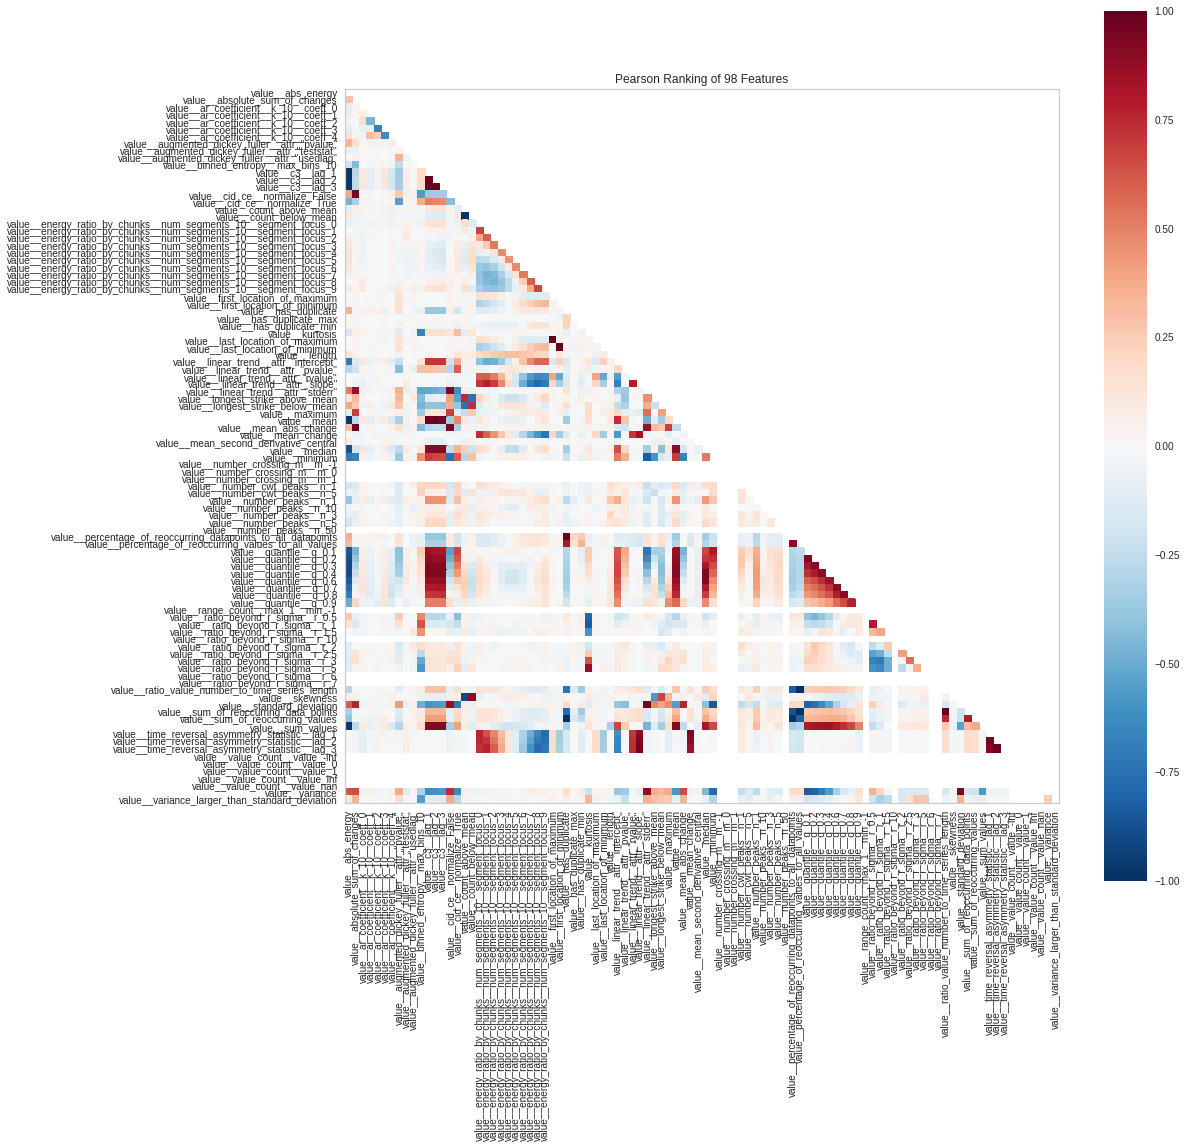

In [48]:
from yellowbrick.features import Rank2D
fig,ax = plt.subplots(figsize = (16,16))
visualizer = Rank2D(ax = ax)
visualizer.fit(X,y=None)
visualizer.transform(X)
visualizer.poof()
